In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive

### Data Processing

In [13]:
scaler = StandardScaler()

In [14]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [15]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [16]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [17]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [19]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(1000)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(200)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()


# df_rest_features

In [20]:
df_rest_02 = df_rest_features.drop(index = df_test_target_index).reset_index()
df_rest_02 = df_rest_02.drop(columns = {df_rest_02.columns[0]})
df_val_target = df_rest_02[['Class']].sample(200)
df_val_target_index = df_val_target.index

df_val_features = df_rest_02.iloc[df_val_target_index]
df_val_features = df_val_features.drop(columns={'Class'}).to_numpy()

df_val_target = df_val_target.to_numpy()
df_val_features.shape, df_val_target.shape

((200, 14), (200, 1))

In [28]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=5
tau=10

### Ancestral Sampling 

In [22]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.11532278 -0.1537106   0.38997932  1.33184714  0.13102111  0.46211855
 -2.77018643  1.03381991 -0.60216216  0.60587861 -0.42405139 -0.08626397
  1.15495016 -1.30690126]


In [23]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [24]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({10.0: 119,
         3.0: 134,
         9.0: 77,
         5.0: 130,
         8.0: 104,
         0.0: 48,
         6.0: 120,
         4.0: 82,
         7.0: 90,
         2.0: 46,
         1.0: 50})

In [25]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.11


### Model implementation with Pyro

In [26]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                   loc=torch.zeros(n_cat), 
                                                   scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [27]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Parameter Tuning

##### Degree of Freedom

In [33]:
degF_range = [4,5,6]

acc_val_degF = []


for degF in degF_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    
    print({degF:acc})
    acc_val_degF.append({degF:acc})
   

[0] ELBO: 9045.6
[1000] ELBO: 3759.1
[2000] ELBO: 2027.2
[3000] ELBO: 1719.0
[4000] ELBO: 1664.6
[5000] ELBO: 1616.9
[6000] ELBO: 1593.6
[7000] ELBO: 1592.1
[8000] ELBO: 1589.5
[9000] ELBO: 1589.2
[10000] ELBO: 1585.9
[11000] ELBO: 1582.2
[12000] ELBO: 1586.9
[13000] ELBO: 1587.9
[14000] ELBO: 1575.9
[15000] ELBO: 1572.2
[16000] ELBO: 1585.4
[17000] ELBO: 1569.6
[18000] ELBO: 1571.8
[19000] ELBO: 1577.3
{4: 0.505}
[0] ELBO: 9422.8
[1000] ELBO: 4468.6
[2000] ELBO: 2403.5
[3000] ELBO: 1806.7
[4000] ELBO: 1693.8
[5000] ELBO: 1652.4
[6000] ELBO: 1628.8
[7000] ELBO: 1616.7
[8000] ELBO: 1612.9
[9000] ELBO: 1599.0
[10000] ELBO: 1602.0
[11000] ELBO: 1606.0
[12000] ELBO: 1601.2
[13000] ELBO: 1580.3
[14000] ELBO: 1578.7
[15000] ELBO: 1578.4
[16000] ELBO: 1583.3
[17000] ELBO: 1584.1
[18000] ELBO: 1583.6
[19000] ELBO: 1574.0
{5: 0.505}
[0] ELBO: 9507.2
[1000] ELBO: 4478.5
[2000] ELBO: 2620.3
[3000] ELBO: 1927.0
[4000] ELBO: 1738.3
[5000] ELBO: 1639.6
[6000] ELBO: 1636.1
[7000] ELBO: 1622.3
[8000] 

In [ ]:
acc_val_degF

##### Tau in Variance

In [34]:
tau_range = [1,10,50,100]

acc_val_tau = []


for tau in tau_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({tau:acc})
    acc_val_tau.append({tau:acc})
   

[0] ELBO: 5241.0
[1000] ELBO: 2195.7
[2000] ELBO: 1741.7
[3000] ELBO: 1639.3
[4000] ELBO: 1620.3
[5000] ELBO: 1596.4
[6000] ELBO: 1585.6
[7000] ELBO: 1574.0
[8000] ELBO: 1576.4
[9000] ELBO: 1569.3
[10000] ELBO: 1568.7
[11000] ELBO: 1565.2
[12000] ELBO: 1561.8
[13000] ELBO: 1568.1
[14000] ELBO: 1566.1
[15000] ELBO: 1563.2
[16000] ELBO: 1570.5
[17000] ELBO: 1559.5
[18000] ELBO: 1553.0
[19000] ELBO: 1563.0
[0] ELBO: 18718.9
[1000] ELBO: 12166.2
[2000] ELBO: 7865.3
[3000] ELBO: 4899.4
[4000] ELBO: 3242.6
[5000] ELBO: 2584.2
[6000] ELBO: 2084.2
[7000] ELBO: 1883.6
[8000] ELBO: 1759.0
[9000] ELBO: 1683.0
[10000] ELBO: 1668.0
[11000] ELBO: 1658.8
[12000] ELBO: 1636.9
[13000] ELBO: 1647.1
[14000] ELBO: 1632.0
[15000] ELBO: 1627.0
[16000] ELBO: 1626.3
[17000] ELBO: 1616.4
[18000] ELBO: 1612.6
[19000] ELBO: 1612.3
[0] ELBO: 88039.0
[1000] ELBO: 80368.0
[2000] ELBO: 73107.1
[3000] ELBO: 66124.6
[4000] ELBO: 59945.8
[5000] ELBO: 53776.1
[6000] ELBO: 48191.8
[7000] ELBO: 44181.8
[8000] ELBO: 39551.

In [35]:
acc_val_tau

[{1: 0.52}, {10: 0.5}, {50: 0.34}, {100: 0.25}]

### Model implementation with Pyro V2

In [36]:
def model_2(X, n_cat,lambda_, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.Normal(torch.zeros(n_cat), 
                                            lambda_*torch.ones(n_cat)).to_event()) # Prior for the bias mean  
    
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

##### lambda

In [38]:
lambda_range = [1,5,10]

acc_val_lambda = []


for lambda_ in lambda_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model_2)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 20000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model_2, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, lambda_, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, lambda_, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({lambda_:acc})
    acc_val_lambda.append({lambda_:acc})
   

[0] ELBO: 273163.9
[1000] ELBO: 266613.3
[2000] ELBO: 259313.1
[3000] ELBO: 253936.4
[4000] ELBO: 247968.8
[5000] ELBO: 241505.3
[6000] ELBO: 237974.6
[7000] ELBO: 230226.3
[8000] ELBO: 225169.3
[9000] ELBO: 220251.1
[10000] ELBO: 215887.1
[11000] ELBO: 209234.5
[12000] ELBO: 204334.3
[13000] ELBO: 198058.8
[14000] ELBO: 192403.3
[15000] ELBO: 192903.0
[16000] ELBO: 184720.9
[17000] ELBO: 183518.2
[18000] ELBO: 176860.0
[19000] ELBO: 177012.8
{1: 0.225}
[0] ELBO: 277370.9
[1000] ELBO: 269811.7
[2000] ELBO: 261738.6
[3000] ELBO: 254303.5
[4000] ELBO: 247930.5
[5000] ELBO: 240285.0
[6000] ELBO: 233156.6
[7000] ELBO: 227619.6
[8000] ELBO: 220331.9
[9000] ELBO: 211206.5
[10000] ELBO: 206878.1
[11000] ELBO: 200568.2
[12000] ELBO: 196470.5
[13000] ELBO: 190484.6
[14000] ELBO: 184052.2
[15000] ELBO: 180768.6
[16000] ELBO: 176024.0
[17000] ELBO: 172298.4
[18000] ELBO: 165955.4
[19000] ELBO: 159504.7
{5: 0.155}
[0] ELBO: 210373.7
[1000] ELBO: 203681.6
[2000] ELBO: 196753.7
[3000] ELBO: 191106.4

#### Final Model training 

In [39]:
degF=5
tau=1

In [40]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4564.7
[1000] ELBO: 2018.6
[2000] ELBO: 1706.6
[3000] ELBO: 1646.4
[4000] ELBO: 1613.7
[5000] ELBO: 1593.5
[6000] ELBO: 1586.8
[7000] ELBO: 1587.4
[8000] ELBO: 1580.5
[9000] ELBO: 1582.7
[10000] ELBO: 1572.6
[11000] ELBO: 1570.0
[12000] ELBO: 1577.7
[13000] ELBO: 1562.1
[14000] ELBO: 1570.3
[15000] ELBO: 1566.8
[16000] ELBO: 1563.6
[17000] ELBO: 1559.8
[18000] ELBO: 1563.5
[19000] ELBO: 1561.0


In [41]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

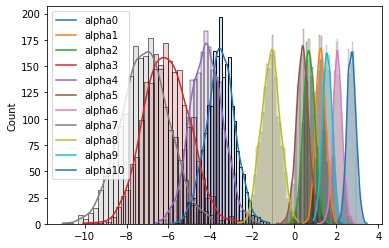

In [42]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

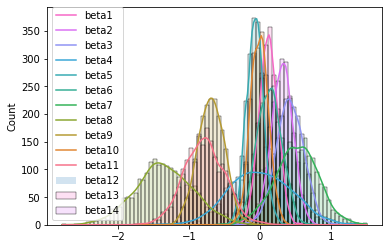

In [43]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [44]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [45]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [2.03000573e-04 6.28986983e-02 1.82710123e-02 2.53336274e-05
 1.18679672e-02 6.77098690e-03 1.01515567e-01 4.15622806e-07
 7.65053522e-02 1.05994695e-01 6.15946970e-01] 10.0
n, p and y  1 [4.51621853e-06 3.23860601e-02 1.68053304e-02 9.88147856e-06
 1.84254572e-08 8.66348242e-01 3.64089151e-02 1.34865701e-07
 4.50602235e-03 1.80459049e-02 2.54849745e-02] 5.0
n, p and y  2 [7.40758405e-04 1.06661255e-01 4.38839330e-02 2.23795271e-06
 1.11070616e-03 1.30362656e-01 1.82128880e-01 2.87775120e-06
 1.31336633e-02 2.38627522e-01 2.83345509e-01] 10.0
n, p and y  3 [1.23313257e-03 5.86389237e-02 9.51281689e-03 1.12862705e-04
 1.04876507e-03 8.54009099e-03 8.47021313e-02 7.14458982e-07
 3.12943576e-01 2.11085532e-01 3.12181453e-01] 8.0
n, p and y  4 [4.25256145e-05 5.90474922e-02 1.37691049e-03 6.24814811e-08
 1.09833577e-04 4.94526080e-02 9.87728042e-02 1.93689630e-05
 1.72481524e-01 2.62061339e-01 3.56635532e-01] 10.0
n, p and y  5 [3.50798289e-04 1.10979362e-01 3.27085163e-02 8.

n, p and y  148 [1.42341468e-02 3.55745524e-02 1.24407889e-02 6.23113433e-05
 2.47241369e-02 7.41843763e-02 7.46550711e-02 2.09888050e-04
 5.04847791e-04 6.66822877e-01 9.65870033e-02] 9.0
n, p and y  149 [1.32157736e-04 7.06968450e-02 1.80306941e-03 1.45580363e-06
 9.00850344e-05 2.96200514e-02 2.68714419e-01 5.28845251e-04
 2.77642672e-01 9.54363288e-02 2.55334070e-01] 8.0
n, p and y  150 [1.30889718e-03 7.76720179e-02 4.81852136e-02 1.66487611e-03
 1.25477525e-03 5.25411757e-03 1.11478157e-01 9.61377002e-07
 3.92401139e-02 2.73470233e-02 6.86593847e-01] 10.0
n, p and y  151 [4.90801864e-03 2.93253046e-03 3.07607682e-03 9.45297996e-01
 1.21568000e-04 1.64324155e-03 6.26676241e-03 3.75554449e-04
 4.00987461e-05 2.18972721e-02 1.34408809e-02] 3.0
n, p and y  152 [2.24858867e-05 2.47313975e-02 9.34249572e-04 1.49820999e-08
 6.97423153e-05 5.89287377e-01 3.84052133e-02 1.70774762e-06
 2.26523624e-02 2.63991865e-01 5.99035840e-02] 5.0
n, p and y  153 [8.42162543e-03 1.39054329e-02 7.36496

n, p and y  303 [1.36521840e-03 3.49306638e-02 6.39547027e-02 3.55479273e-04
 2.50397299e-04 4.60160645e-01 6.49308894e-02 5.05956930e-06
 1.35402004e-04 3.26548922e-01 4.73626213e-02] 5.0
n, p and y  304 [2.50457273e-05 4.08918560e-02 9.27053121e-04 8.13681499e-10
 7.41209568e-04 2.24991113e-01 6.43608456e-02 2.98069502e-07
 1.04991524e-01 4.70948908e-01 9.21221465e-02] 9.0
n, p and y  305 [7.36320416e-01 4.61507272e-03 1.93727756e-03 1.48845100e-02
 3.34387668e-02 2.10734096e-03 1.52979371e-02 2.03804152e-02
 6.27028548e-06 1.50890329e-01 2.01216646e-02] 0.0
n, p and y  306 [7.90278759e-02 1.02135721e-02 1.94921895e-03 1.54296752e-04
 5.84568664e-01 9.77309543e-03 1.98932597e-02 2.79844399e-03
 9.52546495e-05 2.66762786e-01 2.47635329e-02] 4.0
n, p and y  307 [1.08204321e-03 4.48306732e-02 2.48258473e-02 1.52831063e-04
 8.52833015e-05 4.25332241e-02 1.50983680e-01 9.89891627e-03
 5.39534448e-05 4.79127699e-01 2.46425849e-01] 9.0
n, p and y  308 [1.34296106e-06 5.38535202e-02 6.403915

n, p and y  440 [6.45422281e-01 1.54698495e-02 1.13312271e-02 2.06165054e-01
 8.68751201e-03 1.76267084e-03 2.26984219e-02 1.03924649e-03
 9.50204124e-05 3.75964591e-02 4.97322583e-02] 0.0
n, p and y  441 [2.33973258e-03 6.97574665e-02 1.48814073e-02 3.59796638e-04
 1.12436938e-03 2.97469247e-02 1.11919824e-01 7.99924008e-07
 1.70468583e-01 1.63699862e-01 4.35701235e-01] 10.0
n, p and y  442 [9.95902972e-05 5.45319086e-02 2.03983540e-02 1.65584844e-06
 2.59555011e-02 9.16515462e-02 6.53688601e-02 2.18965163e-07
 9.80629033e-03 5.08019548e-01 2.24166526e-01] 9.0
n, p and y  443 [3.32576647e-07 2.68303337e-02 5.33330160e-03 1.40178254e-07
 3.97367969e-06 3.17503590e-03 8.39561864e-02 1.76491703e-09
 4.11632007e-01 2.03789375e-02 4.48689750e-01] 10.0
n, p and y  444 [6.54124424e-04 5.73630395e-02 1.78139753e-02 4.80097426e-04
 3.90809408e-04 1.00662450e-02 1.15775468e-01 5.19302538e-06
 4.60041509e-02 4.18804083e-02 7.09566489e-01] 10.0
n, p and y  445 [2.50624680e-06 9.36917260e-02 1.752

n, p and y  586 [2.42374705e-04 9.88551949e-02 2.17156187e-02 1.42241225e-07
 5.46018214e-03 2.68550974e-01 1.16340406e-01 1.23880453e-05
 6.31834320e-03 2.59702497e-01 2.22801879e-01] 5.0
n, p and y  587 [1.86259966e-04 5.69253947e-02 5.49543349e-02 8.93627800e-04
 2.90542305e-04 2.09791138e-02 9.26869485e-02 2.70763282e-06
 4.43171194e-02 1.37412670e-01 5.91351281e-01] 10.0
n, p and y  588 [1.42692458e-04 6.91370974e-02 2.14455023e-02 3.58706700e-07
 1.27210119e-04 5.06689386e-02 1.41835966e-01 1.20595331e-06
 9.98497472e-03 2.16664815e-01 4.89991239e-01] 10.0
n, p and y  589 [5.05659195e-02 9.85295638e-03 3.20536645e-03 7.85314598e-04
 3.92285292e-01 1.58262803e-02 2.05921771e-02 1.15079511e-02
 1.38696389e-05 4.58277106e-01 3.70877667e-02] 9.0
n, p and y  590 [5.31318350e-04 9.04061634e-02 1.78344732e-01 9.00855351e-07
 1.01397137e-04 3.44511485e-02 2.49462057e-01 2.93784514e-06
 1.40432661e-02 3.84795153e-02 3.94176564e-01] 10.0
n, p and y  591 [1.17414945e-07 3.60878355e-02 9.111

n, p and y  729 [4.53059555e-07 6.31462491e-02 1.24704754e-02 9.08918900e-08
 6.80066886e-05 4.25795703e-03 2.12300132e-01 1.28392266e-08
 2.18507026e-01 1.55956810e-02 4.73653916e-01] 10.0
n, p and y  730 [1.02791453e-04 3.56713614e-02 1.34522227e-02 1.49343174e-06
 1.95217528e-04 8.28560326e-02 1.04448486e-01 1.78100440e-03
 8.13959264e-05 6.26926750e-01 1.34483245e-01] 9.0
n, p and y  731 [2.87540562e-02 1.12600009e-01 2.63726155e-02 5.31095772e-06
 9.42664427e-03 6.12714933e-03 4.66514041e-01 2.40923386e-04
 1.09076622e-01 2.74950367e-02 2.13387592e-01] 6.0
n, p and y  732 [1.10378974e-02 3.59212324e-02 2.81700079e-01 6.38266962e-04
 1.97233166e-03 1.95333789e-02 1.86789297e-01 4.64750827e-03
 4.84205914e-06 2.73468203e-01 1.84286963e-01] 2.0
n, p and y  733 [3.45442836e-03 5.36243991e-02 3.80984066e-01 5.50515552e-05
 2.56739749e-03 1.44846217e-02 2.47929206e-01 2.50863842e-03
 5.04893189e-06 1.05104926e-01 1.89282216e-01] 2.0
n, p and y  734 [2.85302743e-03 7.74962060e-02 2.28755

n, p and y  867 [7.22665360e-05 6.08674447e-02 3.11739255e-02 2.37559345e-05
 4.14845619e-03 2.04582767e-02 1.33202334e-01 8.65656514e-07
 8.69811829e-03 2.74636610e-01 4.66717946e-01] 10.0
n, p and y  868 [6.32502254e-01 1.83834248e-02 2.42825692e-02 7.28586606e-02
 3.91799387e-02 1.17927544e-02 3.23350552e-02 1.74251245e-03
 7.00096722e-05 1.17945375e-01 4.89074458e-02] 0.0
n, p and y  869 [2.31661482e-04 4.37271913e-02 7.46113961e-03 3.99555643e-05
 3.82104060e-04 1.08785243e-02 9.05862050e-02 4.67649578e-07
 1.39742976e-01 1.07696522e-01 5.99253252e-01] 10.0
n, p and y  870 [8.92258530e-04 7.63578340e-02 1.95563886e-02 6.51339451e-06
 6.56872289e-04 2.64865307e-02 1.71965900e-01 4.50312081e-06
 8.08689662e-02 9.67543137e-02 5.26449919e-01] 10.0
n, p and y  871 [1.25877887e-06 4.14952459e-02 6.14678730e-01 1.51201404e-07
 1.29700330e-07 2.30446513e-03 9.02285700e-02 1.43362067e-08
 1.25838886e-04 1.82670665e-03 2.49338889e-01] 2.0
n, p and y  872 [2.70674113e-01 2.71407166e-02 5.137

In [46]:
y_train_pred = y_train_pred[:,0]

In [47]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.52


### Inference and computation of accuracy on the test dataset 

In [48]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_test_pred[n,:])

n, p and y  0 [3.50785843e-04 7.56919183e-02 9.63359298e-03 3.19544708e-06
 1.51521664e-05 1.21878998e-01 1.06172128e-01 1.57035558e-07
 4.32142048e-01 3.76502645e-02 2.16461760e-01] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  1 [1.19869563e-02 5.40283455e-02 6.29549308e-03 1.66618756e-05
 5.28849455e-03 5.01996270e-02 1.30969948e-01 3.97106774e-05
 1.07642360e-01 3.68723886e-01 2.64808517e-01] [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
n, p and y  2 [1.45755984e-04 3.79137837e-02 1.84705466e-03 1.46306136e-08
 9.04968811e-04 1.63316189e-02 6.65201181e-02 3.41083003e-07
 4.60889407e-01 1.06888549e-01 3.08558388e-01] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  3 [1.51746727e-05 2.84115177e-02 9.51224489e-04 1.65932115e-07
 3.59873321e-05 1.42251435e-02 3.44081512e-02 8.67470403e-08
 7.06377753e-01 7.39421995e-02 1.41632596e-01] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  4 [4.14487668e-06 5.27022580e-02 3.73122641e-03 3.57513149e-08
 9.11182241e-06 4.53524470e-02 9.16420744e-02 4.68757

 1.05610664e-02 2.37495970e-02 7.25673454e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  140 [1.28495859e-03 4.97696878e-02 7.24196846e-03 1.77848564e-05
 4.78995570e-04 1.28652963e-02 8.78830133e-02 3.72463195e-06
 4.79037286e-02 1.12458716e-01 6.80092126e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  141 [4.52803246e-05 7.20907527e-02 1.67500793e-02 2.83244223e-06
 2.38103646e-03 3.22782162e-02 1.34711261e-01 2.69678892e-07
 7.37293373e-02 1.79107756e-01 4.88903178e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  142 [1.40857174e-05 4.59812469e-02 3.03949394e-03 3.60224649e-08
 1.40757472e-04 6.23694517e-03 7.64604270e-02 2.30504308e-07
 2.08180482e-01 2.96138466e-02 6.30332448e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  143 [5.12649374e-08 1.92602337e-02 1.60276845e-03 1.30742975e-08
 2.44882789e-08 8.44251127e-04 8.04685782e-02 1.30597423e-08
 7.92412057e-01 8.47678605e-04 1.04564331e-01] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8

In [49]:
y_test_pred = y_test_pred[:,0]

In [50]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.57



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 
* Consider different distributions for priors

Done

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Train model on more data - currently 100 

TODO

* Feature engineer name and album name and retrain logistic regression model using these attributes
* Hyper parameter tuning
* Extend it with FFNN 
* Train model on more data (like 10000)